## Customer Segmentation using K-means algorithm
The aim is to segment customers to different groups in order to apply different business strategies for each type of customer. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
customer = pd.read_csv('customer_segmentation.csv')
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

In [3]:
customer.head(3)

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000


In [4]:
numerical_col = ['age', 'dependent_count', 'estimated_income', 'months_on_book', 'total_relationship_count', 'months_inactive_12_mon', 'credit_limit', 'total_trans_amount', 'total_trans_count', 'avg_utilization_ratio'] 

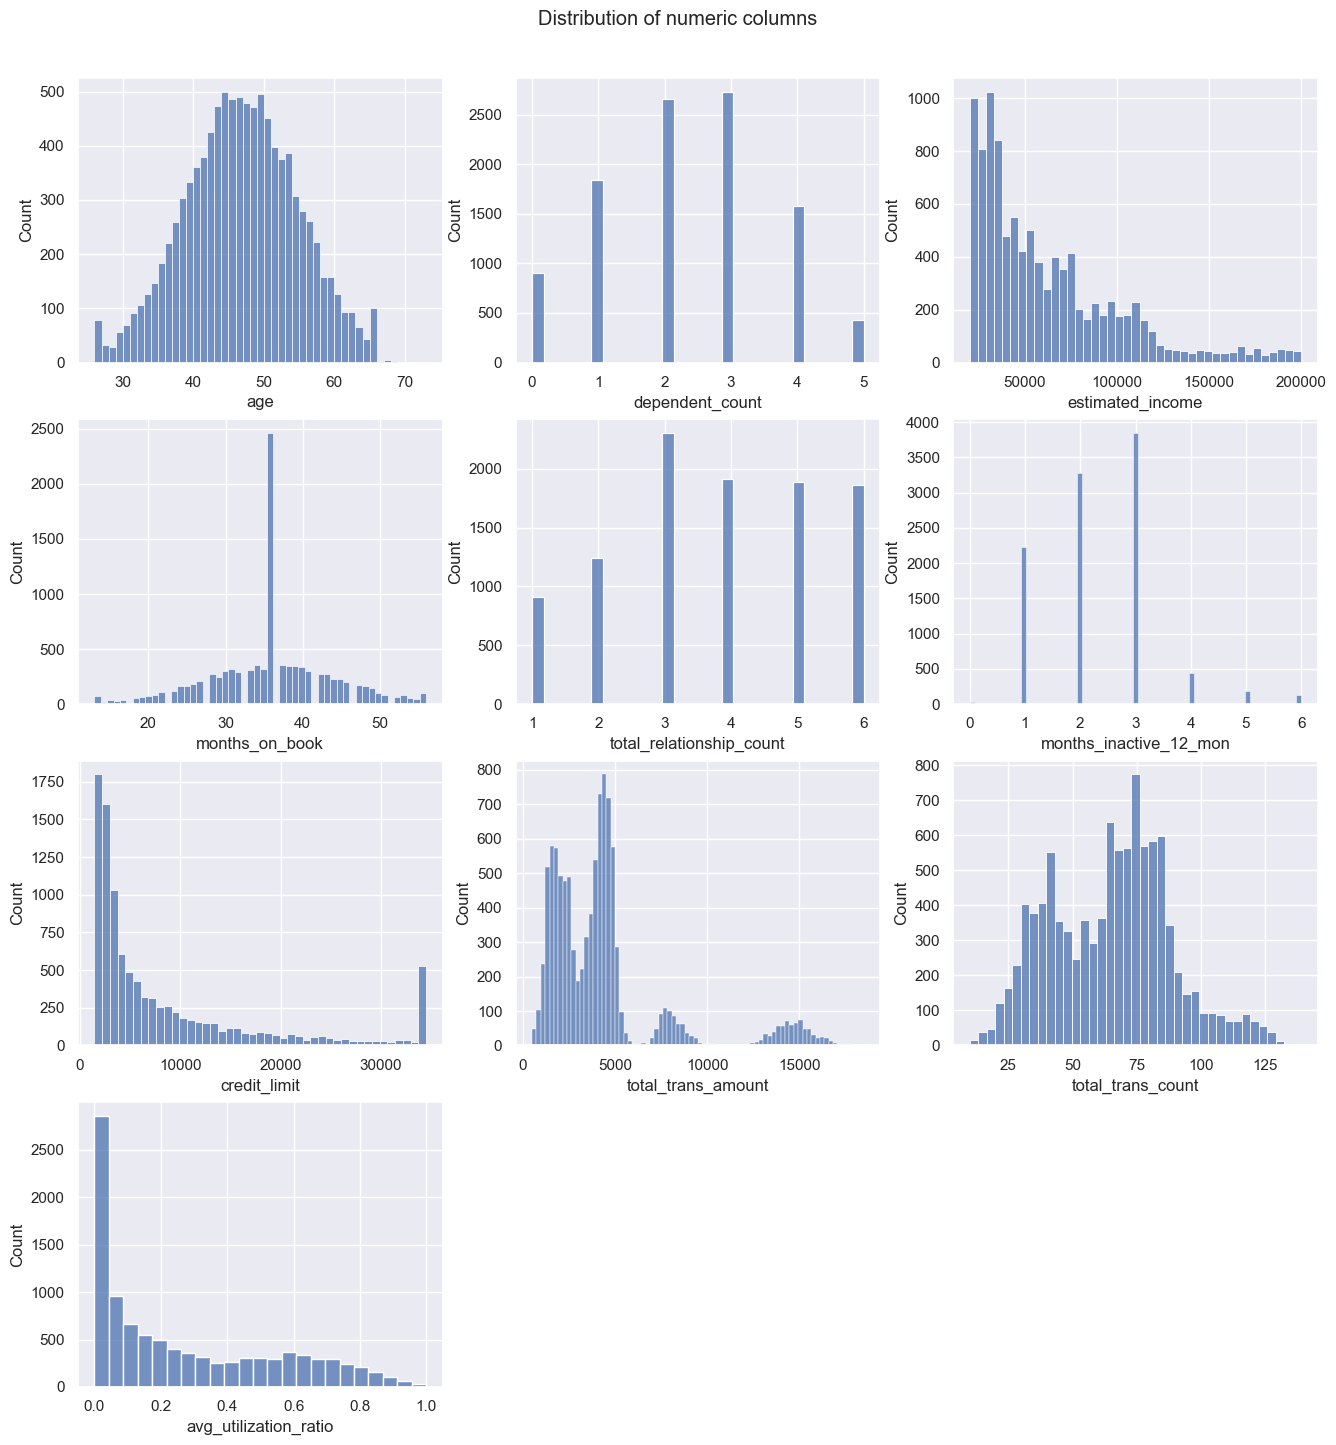

In [5]:
sns.set_theme()
fig = plt.figure(figsize=(16,17))
fig.suptitle('Distribution of numeric columns', y=0.92)
for idx, col in enumerate(numerical_col):
    axis = plt.subplot(4, 3, idx+1)
    sns.histplot(customer[col])
plt.show()

#### Feature selection and scaling

In [6]:
## creating a copy of the data before making modification 
customer_copy = customer.copy(deep=True)

#Modifying the gender column with 1 and 0
customer_copy['gender'] = np.where(customer_copy['gender']=='M', 0, 1)


In [7]:
customer_copy['education_level'].unique()

array(['High School', 'Graduate', 'Uneducated', 'Post-Graduate',
       'College', 'Doctorate'], dtype=object)

In [8]:
# using function to update education level
def education(level):
    if level == 'Uneducated':
        return 0
    elif level == 'High School':
        return 1
    elif level == 'College':
        return 2
    elif level == 'Graduate':
        return 3
    elif level == 'Post-Graduate':
        return 4
    return 5

customer_copy['education_level'] = customer_copy['education_level'].apply(education)


In [9]:
## Using one-hot encoding for marital status
customer_copy = pd.get_dummies(data=customer_copy, columns=['marital_status'], drop_first=True)

In [10]:
#dropping the customer id col before scaling all the data
customer_copy.drop(['customer_id'], axis=1, inplace=True)

In [11]:
scaler = StandardScaler()
scaler.fit(customer_copy)
scaled_customer = scaler.transform(customer_copy)
scaled_customer = pd.DataFrame(scaled_customer)

#### Choosing K clusters

In [12]:
inertias = []
for k in range(1, 11):
    model = KMeans(n_clusters = k, n_init=10)
    model.fit_predict(scaled_customer)
    inertia = model.inertia_
    inertias.append(inertia)


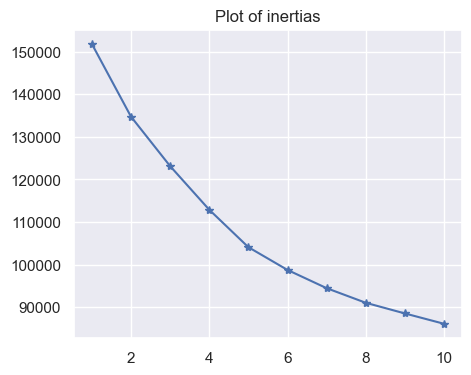

In [13]:
plt.figure(figsize=(5,4))
plt.title('Plot of inertias')
plt.plot(range(1, 11), inertias, marker='*')
plt.show()

Based on the line plot of inertias, there is no distinct elbow curve but the curve can be seen to have have mild deeps at position 2 and 5 of the x-axis.   Therefore it will be appropriate to group the customers into 5 clusters rather than two cluster. Five clusters will reflect more distinct group of customers based on their common characteristics as against two clusters. 

#### Applying KMeans using 5 clusters

In [14]:
model = KMeans(n_clusters = 5, n_init=10)
clusters = model.fit_predict(scaled_customer)
customer['clusters'] = clusters+1
customer['clusters'].value_counts().sort_index()


clusters
1     732
2    3408
3    1937
4     964
5    3086
Name: count, dtype: int64

### Plotting different customer clusters

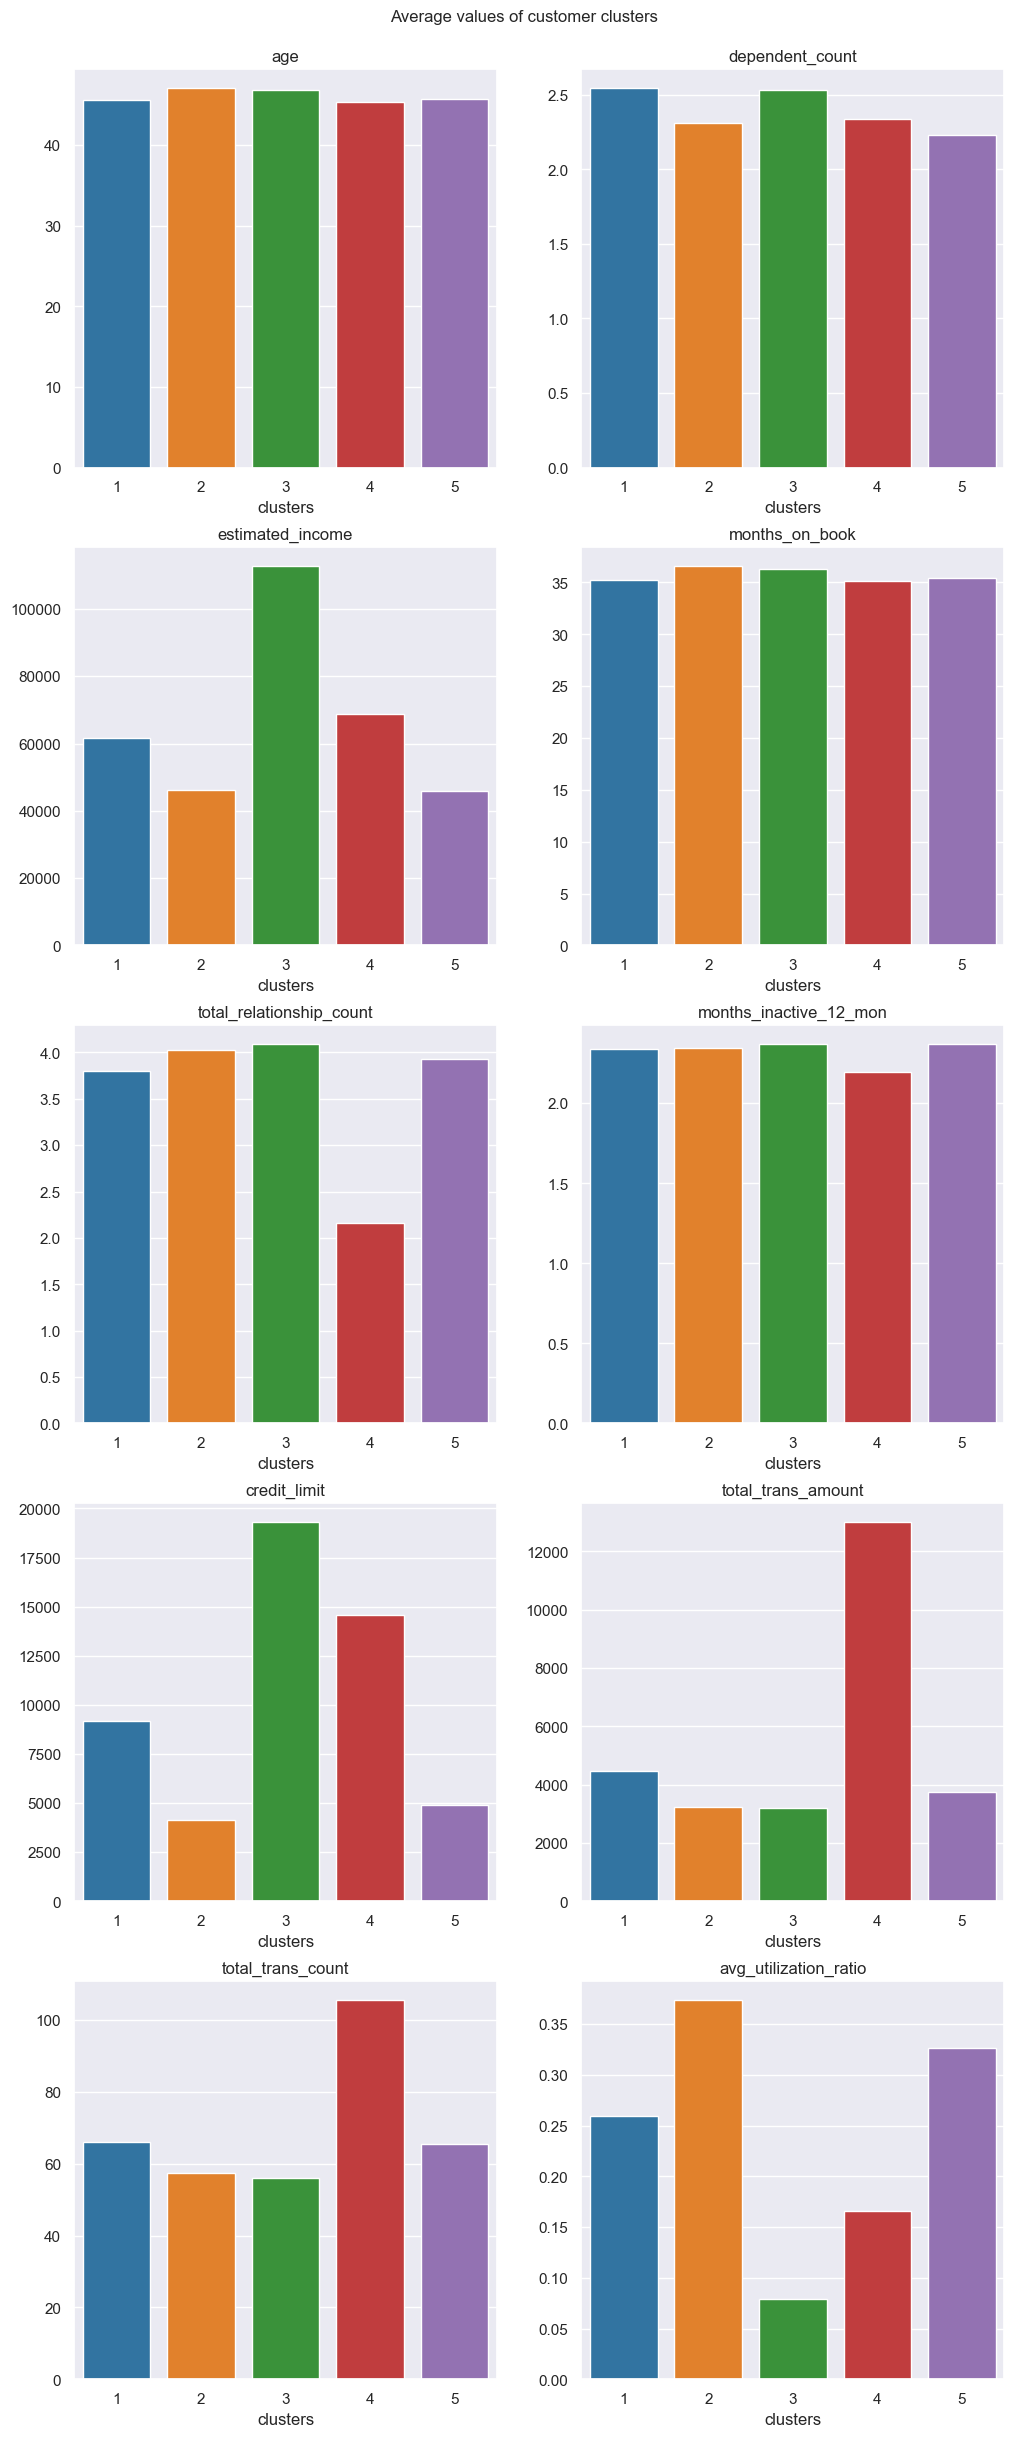

In [15]:
## plotting the customers based on clusters

colors=['gray', 'Vanilla', 'yellow', 'Auburn', 'cosmos']
fig = plt.figure(figsize=(12, 30))
fig.suptitle('Average values of customer clusters', y=0.9, size=12)
for idx, item in enumerate(numerical_col):
    axis = plt.subplot(5, 2, idx+1)
    plt.title(item)
    average = customer.groupby('clusters')[item].mean()
    sns.barplot(x=average.index, y=average.values, ax=axis, hue=average.index, legend=False, palette='tab10')
plt.show()

<Figure size 600x600 with 0 Axes>

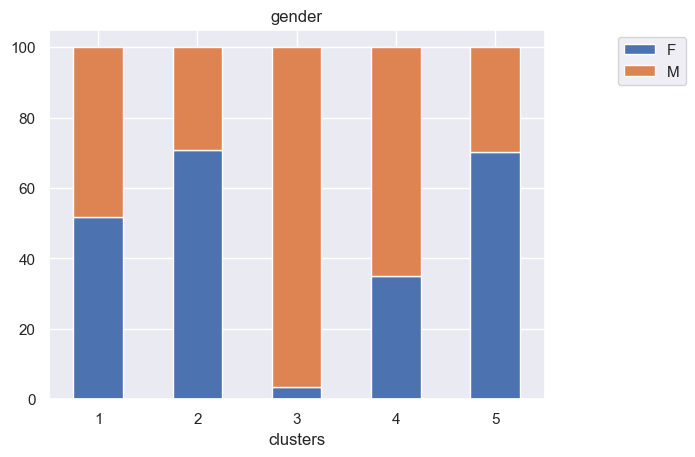

<Figure size 600x600 with 0 Axes>

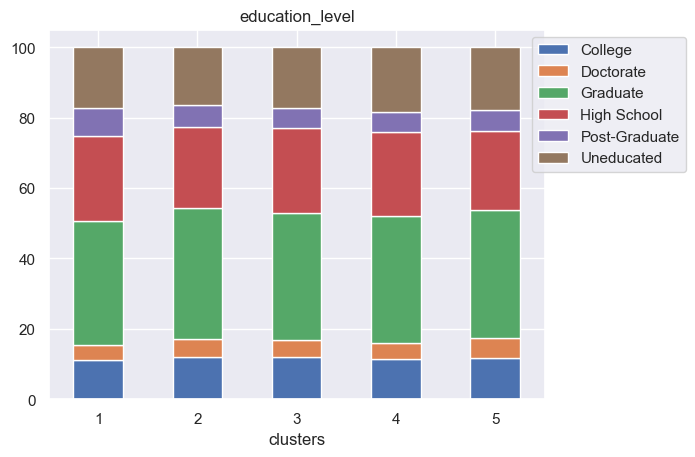

<Figure size 600x600 with 0 Axes>

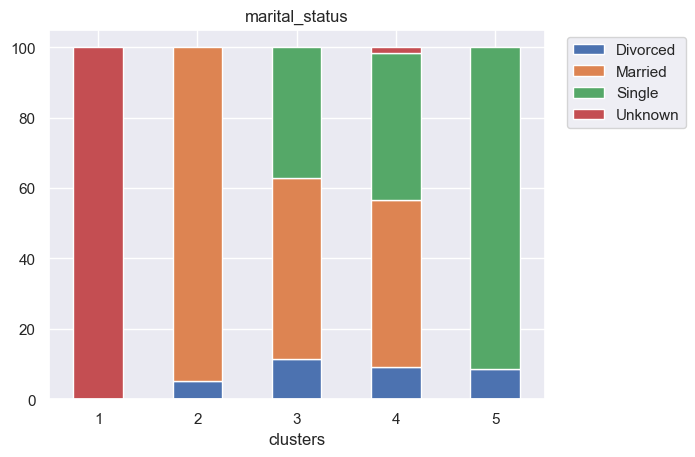

In [16]:
categorical_col = ['gender', 'education_level', 'marital_status']
for item in categorical_col:
    cross_customer = pd.crosstab(index=customer['clusters'], columns=customer[item], values=customer[item], aggfunc='size', normalize='index')*100
    plt.figure(figsize=(6,6))
    cross_customer.plot.bar(stacked=True, title=item)
    plt.legend(loc='upper right',bbox_to_anchor=(0.5, 0.5, 0.8, 0.5))
    plt.xticks(rotation=0)
   # plt.tight_layout()
    plt.show()

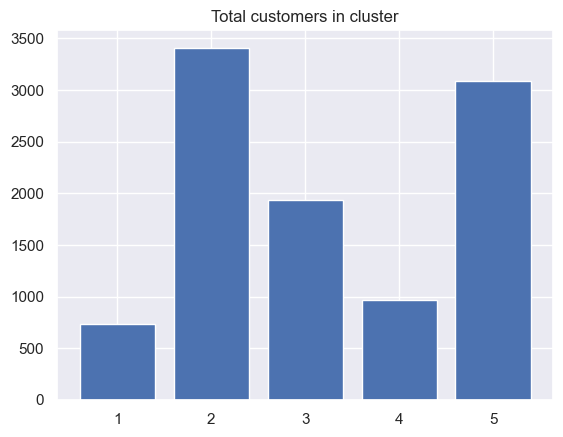

In [17]:
plt.bar(x=customer['clusters'].value_counts().index, height=customer['clusters'].value_counts().values)
plt.title('Total customers in cluster')
plt.show()

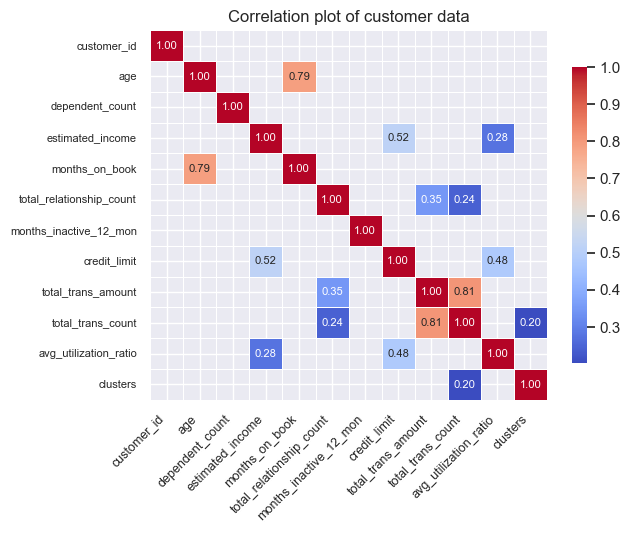

In [18]:
customer_corr = abs(customer.corr(numeric_only=True))

plt.title('Correlation plot of customer data')
sns.heatmap(customer_corr[customer_corr>0.2], annot=True, fmt='.2f', cmap='coolwarm', linewidth=0.5, annot_kws={'size':8}, cbar_kws={'shrink':0.8})
plt.xticks(rotation=45, ha='right', size=9)
plt.yticks(size=8)
#plt.tight_layout()
plt.show()

In [19]:
corr_col = [
    ['age', 'months_on_book'], ['credit_limit', 'estimated_income'], ['total_trans_count', 'total_trans_amount'],
    ['avg_utilization_ratio', 'credit_limit'], ['total_trans_amount', 'total_relationship_count'], 
    ['avg_utilization_ratio', 'estimated_income']
           ]

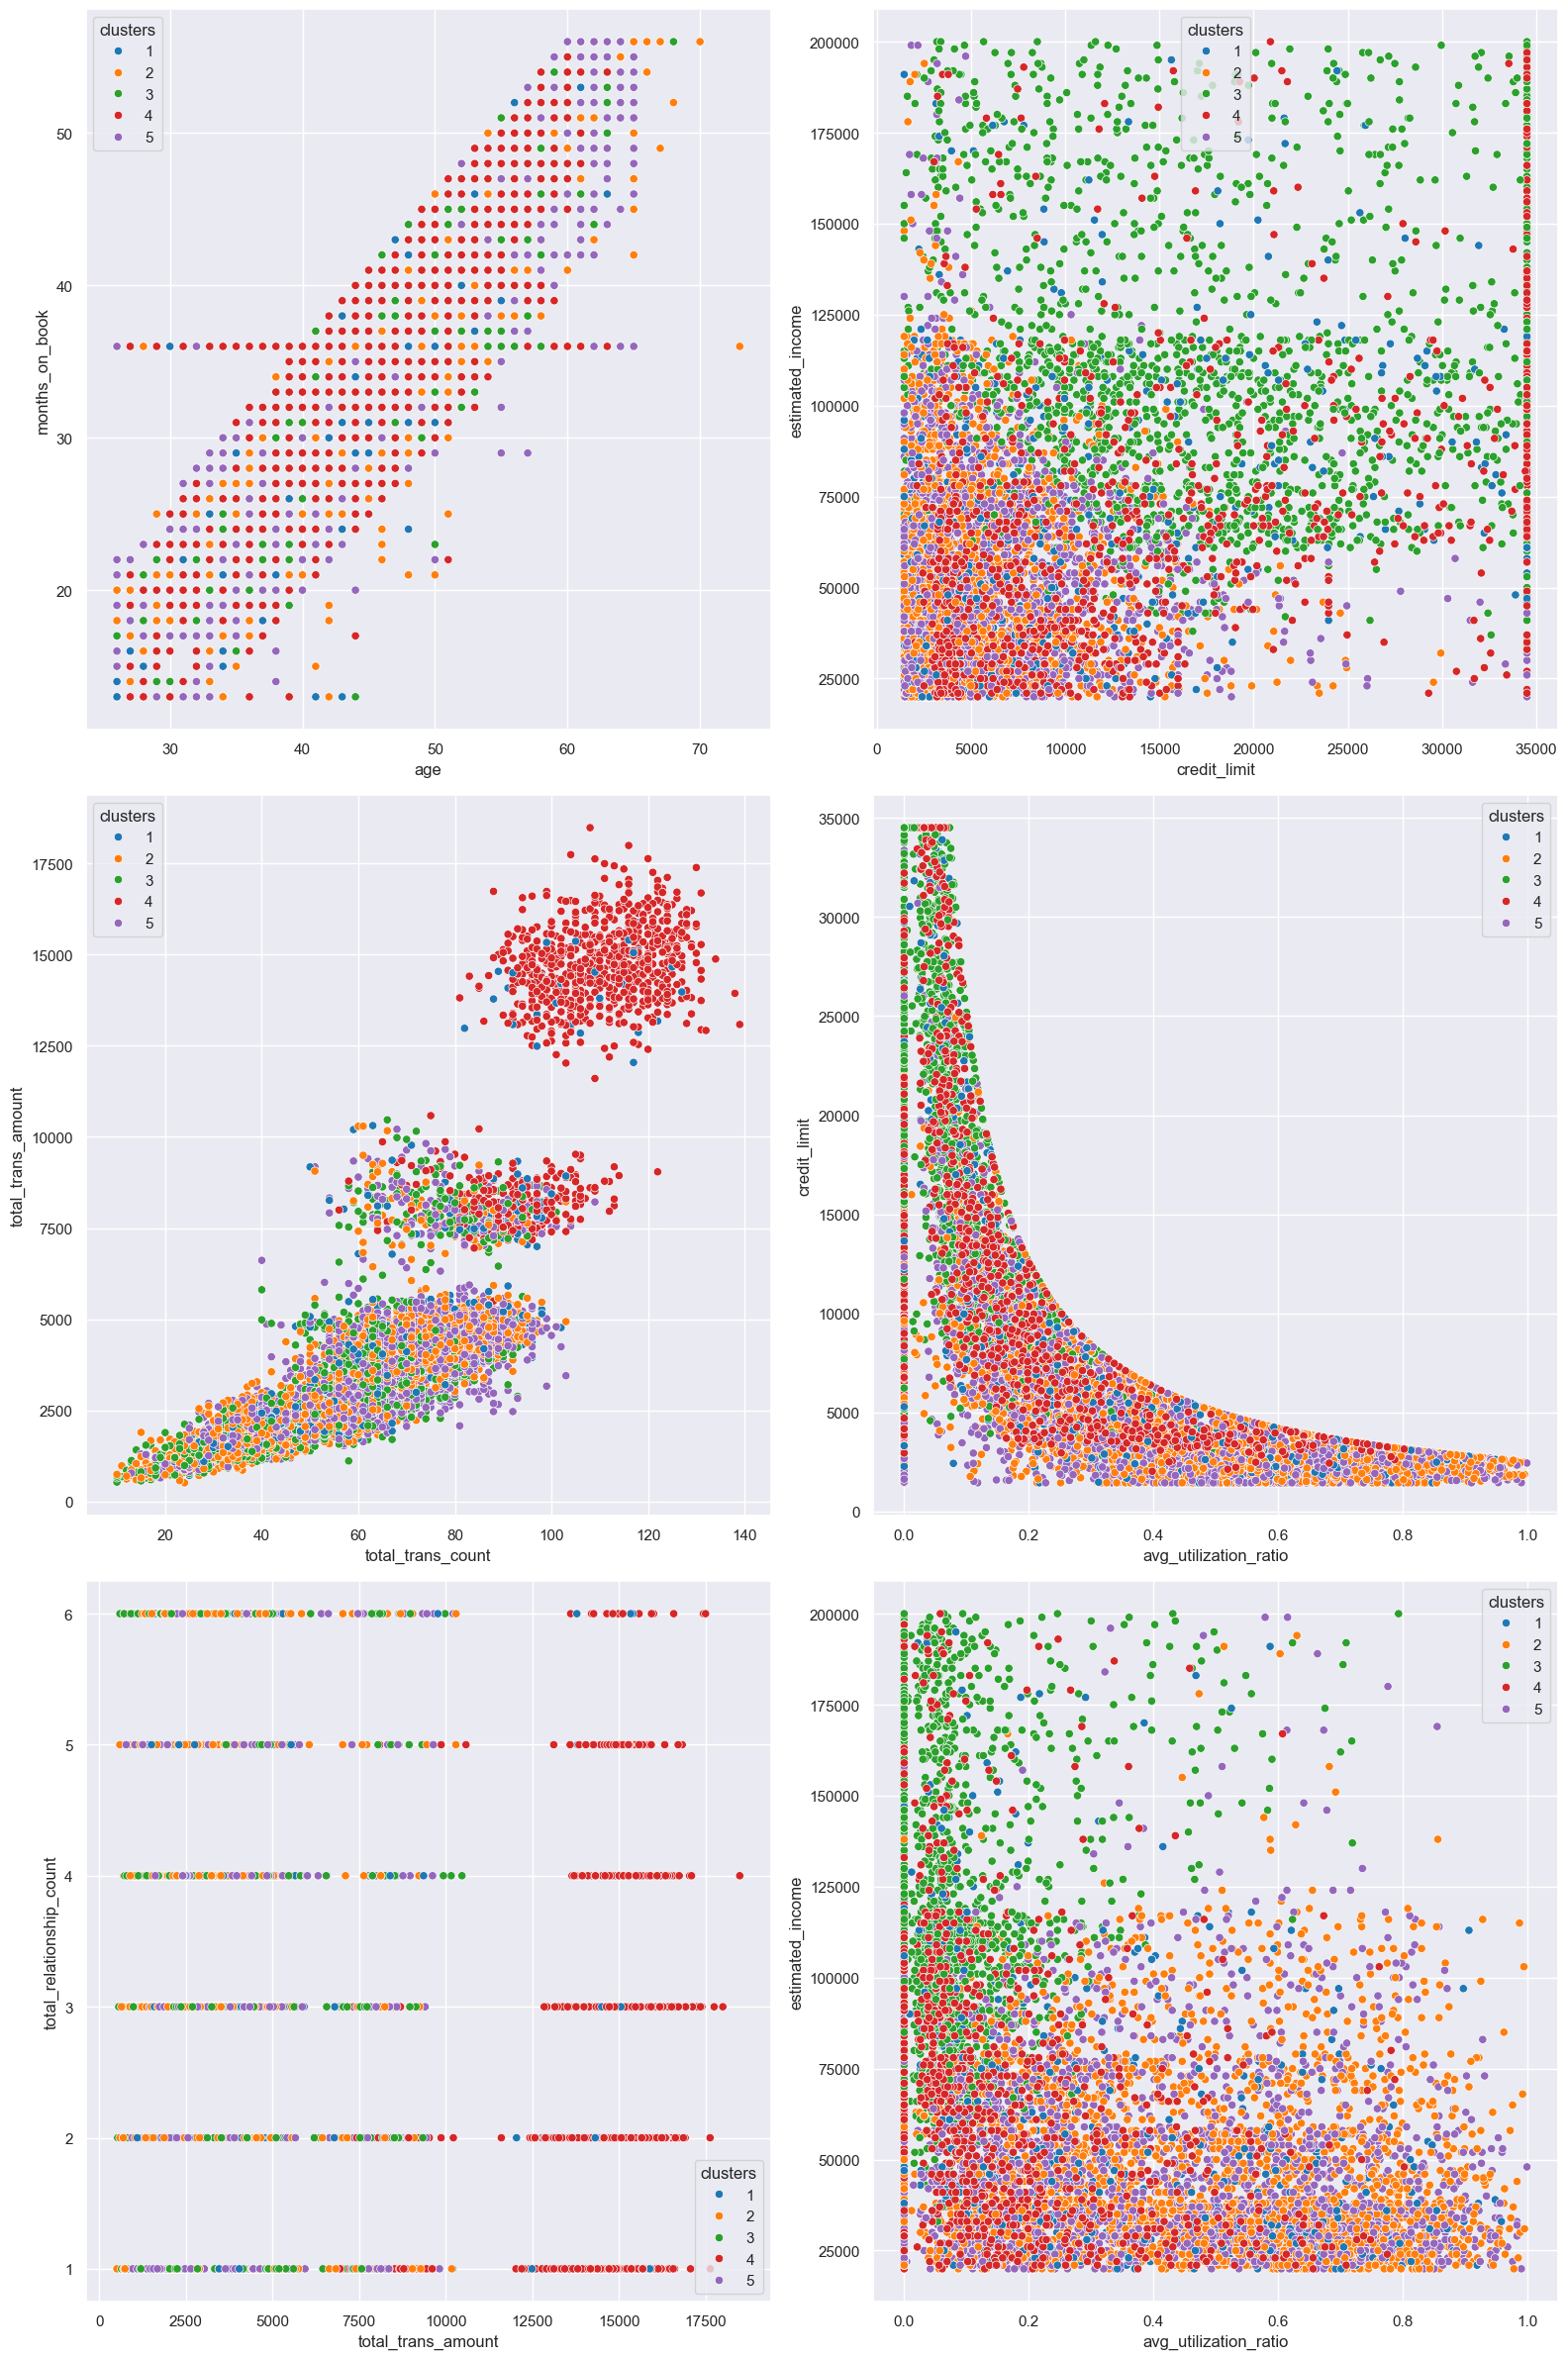

In [20]:
fig = plt.figure(figsize=(16, 24))
for idx, item in enumerate(corr_col):
    axis = plt.subplot(3, 2, idx+1)
    sns.scatterplot(x=customer[item[0]], y=customer[item[1]], ax=axis, hue=customer['clusters'], palette='tab10')
    plt.tight_layout()
plt.show()